# Traffic Sign Detection

Data folders have been manually cleaned to remove any residual files (.DSStore) that are not images. Manual cleaning was done as part of visual inspection of the data folders and since not many such files were present, it was easier to manually dlete them. The data is now ready to be used for training.

#### Import libraries

In [15]:
# import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# from PIL import Image

import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Read from CSV

train_data_shape_encoded = pd.read_csv('processed_data/train_data_shape_encoded.csv')
val_data_shape_encoded = pd.read_csv('processed_data/val_data_shape_encoded.csv')
test_data_shape_encoded = pd.read_csv('processed_data/test_data_shape_encoded.csv')

train_data_type_encoded = pd.read_csv('processed_data/train_data_type_encoded.csv')
val_data_type_encoded = pd.read_csv('processed_data/val_data_type_encoded.csv')
test_data_type_encoded = pd.read_csv('processed_data/test_data_type_encoded.csv')

In [5]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Baseline model

In [24]:
def baseline_mlp(train_data, val_data, output_class, labels):

    
        INPUT_DIM = (28,28,1)
        HIDDEN_LAYER_DIM = 400
        OUTPUT_CLASSES = output_class
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE

        model = tf.keras.Sequential([
        
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
        ])
        
        model.summary()
        #tf.keras.utils.plot_model(model, show_shapes=True)
        model.compile(optimizer='SGD',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['categorical_accuracy'])


        train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
        val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


        batch_size = 28

        train_generator = train_datagen.flow_from_dataframe(
                dataframe=train_data,
                directory='./',
                x_col="Path",
                # y_col=target,
                y_col = train_data.columns[2:].tolist(),
                target_size=(28, 28),
                batch_size=batch_size,
                # class_mode='categorical',
                class_mode='raw',
                color_mode='grayscale')

        validation_generator = val_datagen.flow_from_dataframe(
                dataframe=val_data,
                directory='./',
                x_col="Path",
                # y_col=target,
                y_col = val_data.columns[2:].tolist(),
                target_size=(28, 28),
                batch_size=batch_size,
                # class_mode='categorical',
                class_mode='raw',
                color_mode='grayscale')
        

        history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


        plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                                history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                                metric_name='Accuracy')
        

       # Get the predictions for the validation set
        y_pred = model.predict(validation_generator)

        # Convert predictions to one-hot encoded format
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Get true labels
        y_true = validation_generator.labels
        y_true_classes = np.argmax(y_true, axis=1)

        # Define the class labels (replace this with your actual class labels if needed)
        class_labels = labels

        # Generate the classification report
        report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

        from sklearn.metrics import roc_auc_score, confusion_matrix

        # Calculate the AUC-ROC score
        auc_roc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')  

        # Print the AUC-ROC score
        print("AUC-ROC Score:", auc_roc_score)

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

        # Print the confusion matrix
        print("Confusion Matrix:")
        print(conf_matrix)


        # Print the classification report
        print(report)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 400)            │       314,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         2,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,005 (1.21 MB)

 Trainable params: 316,005 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Found 2219 validated image filenames.
Found 740 validated image filenames.


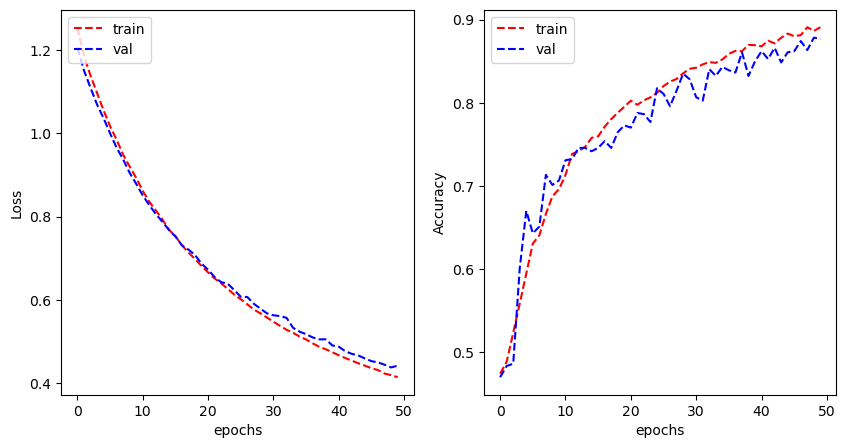

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
AUC-ROC Score: 0.4360016073695938
Confusion Matrix:
[[  5   0  26   9  16]
 [  0   0   2   1   1]
 [ 22   0 166  57 103]
 [  9   0  79  20  38]
 [  6   0 101  25  54]]
              precision    recall  f1-score   support

     diamond       0.12      0.09      0.10        56
         hex       0.00      0.00      0.00         4
       round       0.44      0.48      0.46       348
      square       0.18      0.14      0.16       146
    triangle       0.25      0.29      0.27       186

    accuracy                           0.33       740
   macro avg       0.20      0.20      0.20       740
weighted avg       0.32      0.33      0.32       740



In [25]:
baseline_mlp(train_data_shape_encoded, val_data_shape_encoded, 5, ['diamond', 'hex', 'round', 'square','triangle'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 400)            │       314,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │         6,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,416 (1.22 MB)

 Trainable params: 320,416 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Found 2219 validated image filenames.
Found 740 validated image filenames.


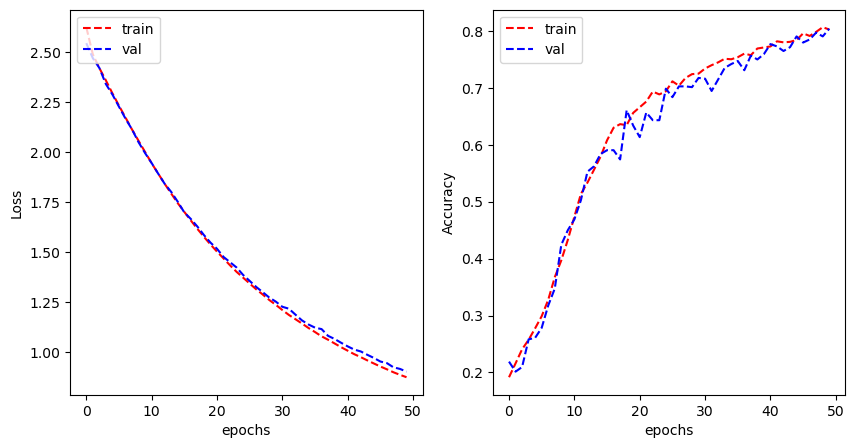

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC-ROC Score: 0.49479411374605003
Confusion Matrix:
[[10  6  0  6  1  2  8  4  6  2  0  6  0  1  0  6]
 [ 8  3  0  3  1  0  2  5  1  5  1  1  0  1  0  9]
 [ 1  2  0  4  0  0  1  1  3  2  0  2  0  0  0  3]
 [ 5  3  0  4  0  2  3  3  8  4  2  8  0  1  0  9]
 [ 3  2  1  0  1  1  2  1  0  2  0  5  0  1  1  2]
 [ 4  1  0  2  0  0  4  2  4  5  0  2  0  0  2  6]
 [ 4  3  0  5  2  0  4  2  6  8  1 16  0  1  1 14]
 [ 8  1  1  0  0  2  5  1  4  7  2  4  0  2  1  7]
 [ 3  4  1  6  1  2  9  2  3  5  1  8  0  2  0 18]
 [ 5  3  1  3  1  0  5  7  7  6  1  4  0  1  2 10]
 [ 4  0  0  2  0  0  4  2  3  3  0  1  0  0  0  3]
 [ 4  2  0  4  1  2  8  5  8  7  0 12  0  2  0 13]
 [ 0  0  0  0  0  0  0  0  0  1  0  3  0  0  0  0]
 [ 3  3  0  3  0  0  0  4  1  3  0  4  0  1  0  9]
 [ 1  1  0  2  1  0  1  5  1  4  0  1  0  1  0  7]
 [11  8  2  7  4  2 12  6  9 10  1 18  0  4  1 39]]
                  precision    recall  f1-score   support

         bicycle       0.14     

In [29]:
baseline_mlp(train_data_type_encoded, val_data_type_encoded, 16, ['bicycle', 'continue', 'crossing',
       'giveway', 'laneend', 'limitedtraffic', 'noentry', 'noparking',
       'parking', 'rightofway', 'roundabout', 'speed', 'stop',
       'trafficdirective', 'traveldirection', 'warning'])

## Convolution Neural Network

In [38]:

def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [56]:
def vcg_cnn(OUTPUT_CLASSES, train_data, val_data, labels):

    model_VGG_1 = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(28, (1, 1), activation='relu', padding='same', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(28, (1, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 2
        tf.keras.layers.Conv2D(56, (1, 1), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(56, (1, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 3
        tf.keras.layers.Conv2D(112, (1, 1), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(112, (1, 1), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])

    model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
    val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


    batch_size = 28

    train_generator = train_datagen.flow_from_dataframe(
                dataframe=train_data,
                directory='./',
                x_col="Path",
                y_col= train_data.columns[2:].tolist(),
                target_size=(28, 28),
                batch_size=batch_size,
                # class_mode='categorical',
                class_mode='raw',
                color_mode='grayscale')

    validation_generator = val_datagen.flow_from_dataframe(
                dataframe=val_data,
                directory='./',
                x_col="Path",
                y_col = val_data.columns[2:].tolist(),
                target_size=(28, 28),
                batch_size=batch_size,
                # class_mode='categorical',
                class_mode='raw',
                color_mode='grayscale')
    
    history_VGG_1 = model_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

    plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    # Get the predictions for the validation set
    y_pred = model_VGG_1.predict(validation_generator)

    # Convert predictions to one-hot encoded format
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = validation_generator.labels
    y_true_classes = np.argmax(y_true, axis=1)

    # Define the class labels (replace this with your actual class labels if needed)
    class_labels = labels

    # Generate the classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

    from sklearn.metrics import roc_auc_score, confusion_matrix

    # Calculate the AUC-ROC score
    auc_roc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')  

    # Print the AUC-ROC score
    print("AUC-ROC Score:", auc_roc_score)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)


    # Print the classification report
    print(report)
    


In [43]:
train_data_shape_encoded.columns

Index(['Path', 'Normalized_Image', 'diamond', 'hex', 'round', 'square',
       'triangle'],
      dtype='object')

Found 2219 validated image filenames.
Found 740 validated image filenames.


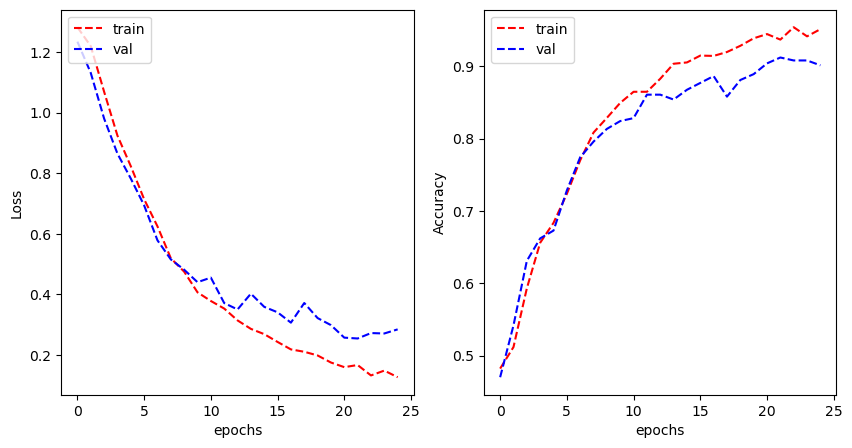

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
AUC-ROC Score: 0.5061327308296412
Confusion Matrix:
[[  2   0  22  16  16]
 [  0   0   2   2   0]
 [ 32   0 160  80  76]
 [ 13   1  59  27  46]
 [ 13   3  88  39  43]]
              precision    recall  f1-score   support

     diamond       0.03      0.04      0.03        56
         hex       0.00      0.00      0.00         4
       round       0.48      0.46      0.47       348
      square       0.16      0.18      0.17       146
    triangle       0.24      0.23      0.23       186

    accuracy                           0.31       740
   macro avg       0.18      0.18      0.18       740
weighted avg       0.32      0.31      0.32       740



In [57]:
vcg_cnn(5, train_data_shape_encoded, val_data_shape_encoded, ['diamond', 'hex', 'round', 'square', 'triangle'])

Found 2219 validated image filenames.
Found 740 validated image filenames.


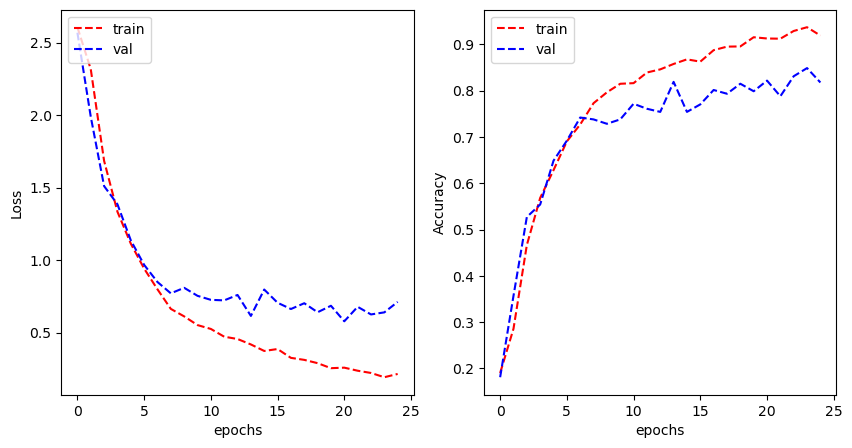

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AUC-ROC Score: 0.5096813046282731
Confusion Matrix:
[[ 6  2  0  4  3  2  1  6  6  6  4  7  0  1  2  8]
 [ 3  0  1  3  1  2  6  3  2  5  1  1  0  1  3  8]
 [ 4  0  0  2  1  2  0  0  0  4  1  2  0  0  1  2]
 [ 3  1  0  6  0  2  5  4  2  3  2  6  1  0  3 14]
 [ 4  2  0  0  1  3  3  0  1  2  0  0  0  1  1  4]
 [ 1  2  1  1  2  1  3  2  1  5  0  3  0  2  3  5]
 [ 3  3  2 10  1  2  4  7  3  8  2  4  0  3  2 13]
 [ 3  2  0  5  1  3  4  3  3  5  3  6  0  1  0  6]
 [ 3 10  2  6  3  3  1  6  4  4  2  4  1  0  4 12]
 [ 4  2  3 10  0  1  5  8  6  4  0  2  0  0  2  9]
 [ 3  0  0  1  1  2  4  0  0  4  1  1  0  0  1  4]
 [ 6  1  0  4  2  5  6  3  4  6  4  5  0  2  3 17]
 [ 0  0  0  0  0  0  0  0  1  1  0  1  0  0  0  1]
 [ 3  0  0  4  1  0  3  1  2  1  1  3  0  1  1 10]
 [ 6  2  0  1  0  1  2  1  1  4  0  1  0  0  1  5]
 [ 5 14  2 10  3  5 18  6  9 10  2 17  0  3  5 25]]
                  precision    recall  f1-score   support

         bicycle       0.11      

In [59]:
vcg_cnn(16, train_data_type_encoded, val_data_type_encoded, ['bicycle', 'continue', 'crossing',
       'giveway', 'laneend', 'limitedtraffic', 'noentry', 'noparking',
       'parking', 'rightofway', 'roundabout', 'speed', 'stop',
       'trafficdirective', 'traveldirection', 'warning'])

## weight regularisation

In [61]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(5),
])

In [62]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


batch_size = 28

train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_data_shape_encoded,
            directory='./',
            x_col="Path",
            y_col= train_data_shape_encoded.columns[2:].tolist(),
            target_size=(28, 28),
            batch_size=batch_size,
            # class_mode='categorical',
            class_mode='raw',
            color_mode='grayscale')

validation_generator = val_datagen.flow_from_dataframe(
            dataframe=val_data_shape_encoded,
            directory='./',
            x_col="Path",
            y_col = val_data_shape_encoded.columns[2:].tolist(),
            target_size=(28, 28),
            batch_size=batch_size,
            # class_mode='categorical',
            class_mode='raw',
            color_mode='grayscale')

Found 2219 validated image filenames.


Found 740 validated image filenames.


In [65]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_48" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 28, 28, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
  • training=True
  • mask=None

In [64]:
# Get the predictions for the validation set
y_pred = model_VGG_2.predict(validation_generator)

# Convert predictions to one-hot encoded format
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = validation_generator.labels
y_true_classes = np.argmax(y_true, axis=1)

# Define the class labels (replace this with your actual class labels if needed)
class_labels = ['diamond', 'hex', 'round', 'square', 'triangle']

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

from sklearn.metrics import roc_auc_score, confusion_matrix

# Calculate the AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_pred, multi_class='ovr')  

# Print the AUC-ROC score
print("AUC-ROC Score:", auc_roc_score)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


# Print the classification report
print(report)



ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_48" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (28, 28, 28, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(28, 28, 28, 1), dtype=float32)
  • training=False
  • mask=None

### Data Augmentation